# Homework 2, *part 1* (40 points)

This warm-up problem set is provided to help you get used to PyTorch.

Please, only fill parts marked with "`Your code here`".

In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

import torch
assert torch.__version__ >= '1.0.0'

To learn best practices $-$ for example,

* how to choose between `.sqrt()` and `.sqrt_()`,
* when to use `.view()` and how is it different from `.reshape()`,
* which `dtype` to use,

$-$ you are expected to google a lot, read tutorials on the Web and study documentation.

Quick documentation on functions and modules is available with `?` and `help()`, like so:

In [2]:
help(torch.sqrt)

Help on built-in function sqrt:

sqrt(...)
    sqrt(input, out=None) -> Tensor
    
    Returns a new tensor with the square-root of the elements of :attr:`input`.
    
    .. math::
        \text{out}_{i} = \sqrt{\text{input}_{i}}
    
    Args:
        input (Tensor): the input tensor
        out (Tensor, optional): the output tensor
    
    Example::
    
        >>> a = torch.randn(4)
        >>> a
        tensor([-2.0755,  1.0226,  0.0831,  0.4806])
        >>> torch.sqrt(a)
        tensor([    nan,  1.0112,  0.2883,  0.6933])



In [3]:
# to close the Jupyter help bar, press `Esc` or `q`
?torch.cat

Docstring:
cat(tensors, dim=0, out=None) -> Tensor

Concatenates the given sequence of :attr:`seq` tensors in the given dimension.
All tensors must either have the same shape (except in the concatenating
dimension) or be empty.

:func:`torch.cat` can be seen as an inverse operation for :func:`torch.split`
and :func:`torch.chunk`.

:func:`torch.cat` can be best understood via examples.

Args:
    tensors (sequence of Tensors): any python sequence of tensors of the same type.
        Non-empty tensors provided must have the same shape, except in the
        cat dimension.
    dim (int, optional): the dimension over which the tensors are concatenated
    out (Tensor, optional): the output tensor

Example::

    >>> x = torch.randn(2, 3)
    >>> x
    tensor([[ 0.6580, -1.0969, -0.4614],
            [-0.1034, -0.5790,  0.1497]])
    >>> torch.cat((x, x, x), 0)
    tensor([[ 0.6580, -1.0969, -0.4614],
            [-0.1034, -0.5790,  0.1497],
            [ 0.6580, -1.0969, -0.4614],
        

## Task 1 (3 points)

Use tensors only: **no lists, loops, numpy arrays etc.**

$\rho(\theta)$ is defined in polar coordinate system:

$$\rho(\theta) = (1 + 0.9 \cdot \cos{8\theta} ) \cdot (1 + 0.1 \cdot \cos{24\theta}) \cdot (0.9 + 0.05 \cdot \cos {200\theta}) \cdot (1 + \sin{\theta})$$

1. Create a regular grid of 1000 values of $\theta$ between $-\pi$ and $\pi$.
2. Compute $\rho(\theta)$ at these values.
3. Convert it into Cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)).

In [4]:
theta = torch.linspace(-math.pi, math.pi, 1000)
assert theta.shape == (1000,)

rho = (1. + .9*torch.cos(8*theta)) * (1. + .1 * torch.cos(24*theta)) * (.9 + .05 * torch.cos(200*theta)) * (1. + torch.sin(theta))
assert torch.is_same_size(rho, theta)

x, y = rho*torch.cos(theta), rho*torch.sin(theta)

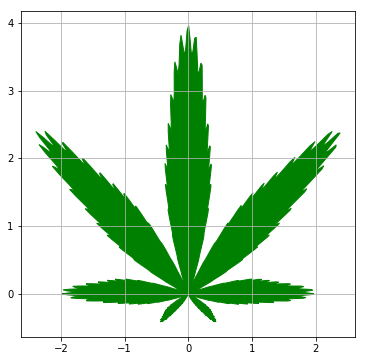

In [5]:
# Run this cell and make sure the plot is correct
plt.figure(figsize=[6,6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

## Task 2 (7 points)

Use tensors only: **no lists, loops, numpy arrays etc.**

We will implement [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway's_Game_of_Life) in PyTorch.

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)

If you skipped the URL above, here are the rules:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* At one step in time, the generation update happens:
  * Any living cell that has 2 or 3 neighbors survives, otherwise (0,1 or 4+ neighbors) it dies
  * Any cell with exactly 3 neighbors becomes alive if it was dead

You are given a reference numpy implementation of the update step. Your task is to convert it to PyTorch.

In [6]:
from scipy.signal import correlate2d as conv2d

def numpy_update(alive_map):
    # Count neighbours with convolution
    conv_kernel = np.array([[1,1,1],
                            [1,0,1],
                            [1,1,1]])
    
    num_alive_neighbors = conv2d(alive_map, conv_kernel, mode='same')
    
    # Apply game rules
    born = np.logical_and(num_alive_neighbors == 3, alive_map == 0)
    survived = np.logical_and(np.isin(num_alive_neighbors, [2,3]), alive_map == 1)
    
    np.copyto(alive_map, np.logical_or(born, survived))

In [7]:
def torch_update(alive_map):
    """
    Game of Life update function that does to `alive_map` exactly the same as `numpy_update`.
    
    :param alive_map: `torch.tensor` of shape `(height, width)` and dtype `torch.float32`
        containing 0s (dead) an 1s (alive)
    """
    k = (
        torch.tensor([
            [1, 1, 1],
            [1, 0, 1],
            [1, 1, 1]
        ])
        .unsqueeze(0) # 1 output channel
        .unsqueeze(0) # which pulls values from 1 input channel
        .type(torch.float32) # Because torch.conv2d is \sout{stupid} not polymorphic
    )
    convolvable_map = (
        alive_map
        .unsqueeze(0) # 1 batch
        .unsqueeze(0) # 1 input channel
    )
    n_neighbours = (
        torch.conv2d(convolvable_map, k, padding=1)
        .squeeze(0)
        .squeeze(0)
    )
    survived = (alive_map == 1) & (2 <= n_neighbours ) & (n_neighbours <= 3)
    born = (alive_map == 0) & (n_neighbours == 3)
    alive_map.copy_(survived | born)   
    return alive_map

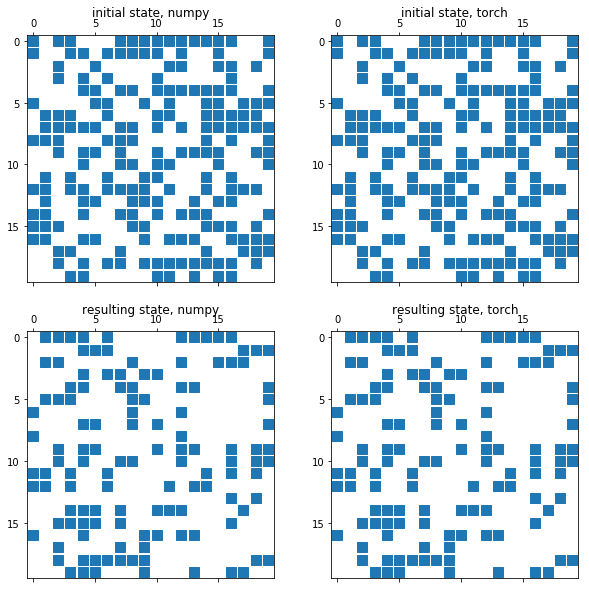

In [8]:
fig, ((np0, t0), (np1, t1)) = plt.subplots(2, 2, figsize=(10, 10))
MS = 10.
# Generate a random initial map
alive_map_numpy = np.random.choice([0, 1], p=(0.5, 0.5), size=(20, 20))
alive_map_torch = torch.tensor(alive_map_numpy).float().clone()
np0.spy(alive_map_numpy, markersize=MS)
np0.set_title('initial state, numpy')
t0.spy(alive_map_torch.numpy(), markersize=MS)
t0.set_title('initial state, torch')

numpy_update(alive_map_numpy)
torch_update(alive_map_torch)
np1.spy(alive_map_numpy, markersize=MS)
np1.set_title('resulting state, numpy')
t1.spy(alive_map_torch.numpy(), markersize=MS)
t1.set_title('resulting state, torch')

# results should be identical
#assert np.allclose(alive_map_torch.numpy(), alive_map_numpy), \
#    "Your PyTorch implementation doesn't match numpy_update."
#print("Well done!")

plt.show()

In [9]:
# Generate a random initial map
alive_map_numpy = np.random.choice([0, 1], p=(0.5, 0.5), size=(100, 100))
alive_map_torch = torch.tensor(alive_map_numpy).float().clone()

numpy_update(alive_map_numpy)
torch_update(alive_map_torch)

# results should be identical
assert np.allclose(alive_map_torch.numpy(), alive_map_numpy), \
    "Your PyTorch implementation doesn't match numpy_update."
print("Well done!")

Well done!


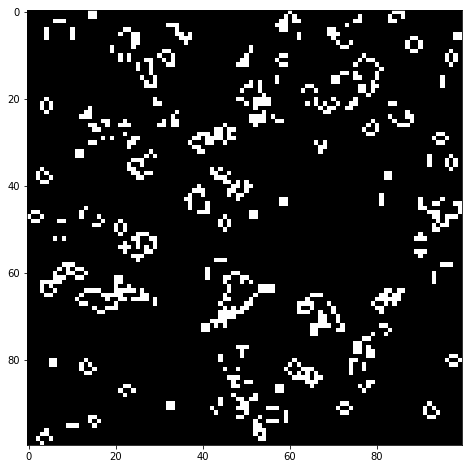

FigureCanvasNbAgg()

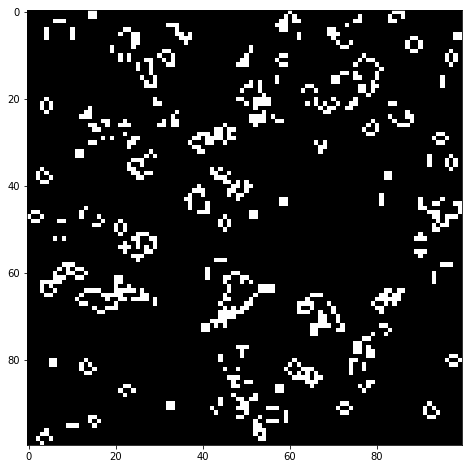

In [10]:
# begin For JUPYTERLAB
%matplotlib widget
plt.ion()
handle = display(None, display_id=True)
# end

# initialize game field
alive_map = np.random.choice([0, 1], size=(100, 100))
alive_map = torch.tensor(alive_map).float()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    torch_update(alive_map)
    
    # re-draw image
    ax.clear()
    ax.imshow(alive_map.numpy(), cmap='gray')
    fig.canvas.draw()
    handle.update(fig)

FigureCanvasNbAgg()

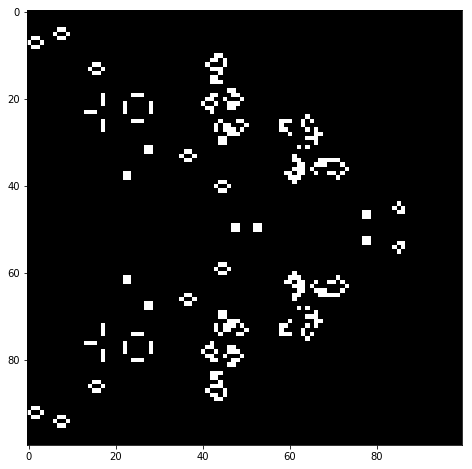

In [11]:
# A fun setup for your amusement
alive_map = np.arange(100) % 2 + np.zeros([100, 100])
alive_map[48:52, 50] = 1

alive_map = torch.tensor(alive_map).float()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
fig.show()

for _ in range(150):
    torch_update(alive_map)
    ax.clear()
    ax.imshow(alive_map.numpy(), cmap='gray')
    fig.canvas.draw()

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE)

## Task 3 (30 points)

You have to solve yet another character recognition problem: 10 letters, ~14 000 train samples.

For this, we ask you to build a multilayer perceptron (*i.e. a neural network of linear layers*) from scratch using **low-level** PyTorch interface.

Requirements:
1. at least 82% accuracy
2. at least 2 linear layers
3. use [softmax followed by categorical cross-entropy](https://gombru.github.io/2018/05/23/cross_entropy_loss/)

**You are NOT allowed to use**
* numpy arrays
* `torch.nn`, `torch.optim`
* convolutions

Tips:

* Pick random batches (either shuffle data before each epoch or sample each batch randomly).
* Do not initialize weights with zeros ([learn why](https://stats.stackexchange.com/questions/27112/danger-of-setting-all-initial-weights-to-zero-in-backpropagation)). Gaussian noise with small variance will do.
* 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve.
* To improve accuracy, consider changing layers' sizes, nonlinearities, optimization methods, weights initialization.
* Don't use GPU yet.

**Reproducibility requirement**: you have to format your code cells so that `Cell -> Run All` on a fresh notebook **reliably** trains your model to the desired accuracy in a couple of minutes and reports the accuracy reached.

Happy googling!

In [12]:
np.random.seed(666)
torch.manual_seed(666)

from notmnist import load_notmnist
letters = 'ABCDEFGHIJ' 
X_train, y_train, X_test, y_test = map(torch.tensor, load_notmnist(letters=letters))
X_train.squeeze_()
X_test.squeeze_();

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]


FigureCanvasNbAgg()

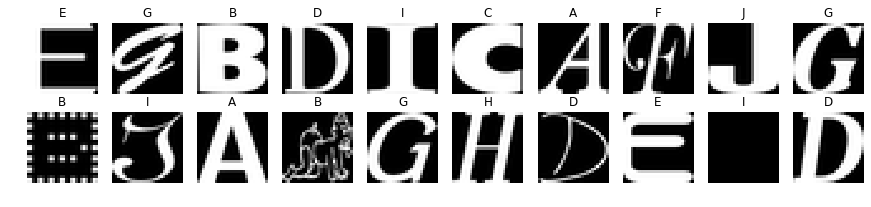

In [13]:
fig, axarr = plt.subplots(2, 10, figsize=(15,3))

for idx, ax in enumerate(axarr.ravel()):
    ax.imshow(X_train[idx].numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(letters[y_train[idx]])

The cell below has an example layout for encapsulating your neural network. Feel free to modify the interface if you need to (add arguments, add return values, add methods etc.). For example, you may want to add a method `do_gradient_step()` that executes one optimization algorithm (SGD / Adadelta / Adam / ...) step.

In [14]:
X_train.shape, y_train.shape, torch.unique(y_train).size()

(torch.Size([14043, 28, 28]), torch.Size([14043]), torch.Size([10]))

In [15]:
import functools
import functional
import itertools
import abc

class ParameterizedModel(abc.ABC):
    def __init__(self):
        self.training = True
    def set_mode(self, training: bool):
        self.training = training
    @abc.abstractmethod
    def forward(self, input):
        return input
    @abc.abstractmethod
    def parameters(self):
        return tuple()
    def requires_grad_(self, requires_grad):
        for p in self.parameters():
            p.requires_grad_(requires_grad)

class Sequential(ParameterizedModel):
    def __init__(self, *layers: ParameterizedModel):
        super(Sequential, self).__init__()
        self.layers = layers
        # self._forward = functools.reduce(functional.compose, self.layers, functional.id)
    def forward(self, input):
        # return self._forward(*input)
        for layer in self.layers:
            input = layer.forward(input)
        return input
    def parameters(self):
        return sum(map(lambda x: x.parameters(), self.layers), tuple())
    def set_mode(self, training: bool):
        super(Sequential, self).set_mode(training)
        for layer in self.layers:
            layer.set_mode(training)


class Linear(ParameterizedModel):
    def __init__(self, n_in, n_out, bias=True):
        super(Linear, self).__init__()
        self.mat = torch.Tensor(n_in,
                                n_out) # row-centric
        self.bias = torch.Tensor(1, n_out)
    def forward(self, input):
        input = input @ self.mat # malloc
        input += self.bias
        return input
    def parameters(self):
        return (self.mat, self.bias)

class Conv2d(ParameterizedModel):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, **kwargs):
        super(Conv2d, self).__init__()
        self._kwargs = kwargs
        kernel_size = kernel_size if isinstance(kernel_size, tuple) else 2 * (kernel_size,)
        # self._kwargs['kernel_size'] = kernel_size
        self._kwargs['padding'] = padding
        self.weights = torch.empty(out_channels, in_channels, *kernel_size)
    def forward(self, input):
        return torch.conv2d(input, self.weights, **self._kwargs)
    def parameters(self):
        return (self.weights,)

class Apply(ParameterizedModel):
    def __init__(self, func, *args, **kwargs):
        super(Apply, self).__init__()
        self.func = func
        self._args = args
        self._kwargs = kwargs
    def forward(self, input):
        return self.func(input, *self._args, **self._kwargs)
    def parameters(self):
        return tuple()
    
class Combine(ParameterizedModel):
    def __init__(self, *layers, combinator=torch.cat):
        super(Combine, self).__init__()
        self.layers = layers
        self.combinator = combinator
    def forward(self, input):
        return self.combinator([layer.forward(input)
                                for layer in self.layers])
    def parameters(self):
        return sum(map(lambda x: x.parameters(), self.layers), tuple())
    def set_mode(self, training: bool):
        super(Combine, self).set_mode(training)
        for layer in self.layers:
            layer.set_mode(training)
    
class Identity(ParameterizedModel):
    def forward(self, input):
        return input
    def parameters(self):
        return tuple()

class Dropout(ParameterizedModel):
    def __init__(self, p):
        super(Dropout, self).__init__()
        self.p = p
    def forward(self, input):
        return torch.dropout(input, p=self.p, train=self.training)
    def parameters(self):
        return tuple() 
    
class Flatten(ParameterizedModel):
    def forward(self, input):
        return torch.flatten(input, start_dim=1)
    def parameters(self):
        return tuple()
    


class PrintShape(ParameterizedModel):
    def __init__(self, comment):
        super(PrintShape, self).__init__()
        self.comment = comment
    def forward(self, input):
        print('[I] {}: {}'.format(self.comment, input.shape))
        return input
    def parameters(self):
        return tuple()


class WarnAboutNans(ParameterizedModel):
    def __init__(self, comment):
        super(WarnAboutNans, self).__init__()
        self.comment = comment
    def forward(self, input):
        nans = torch.isnan(input)
        infs = torch.isinf(input)
        if torch.any(nans):
        	print('[W] {}: {} NaNs'.format(self.comment, torch.sum(nans).item()))
        if torch.any(infs):
        	print('[W] {}: {} Inftys'.format(self.comment, torch.sum(infs).item()))
        return input
    def parameters(self):
        return tuple()

class PredictiveModel(ParameterizedModel):
    def __init__(self, model):
        self.model = model
    def forward(self, input):
        training = self.model.training
        try:
            self.model.set_mode(training=False)
            return self.model.forward(input)
        finally:
            self.model.set_mode(training=training)
    def predict(self, input):
        """
        images: `torch.tensor` of shape `batch_size x height x width`
            and dtype `torch.float32`.
        
        returns: `output`, a `torch.tensor` of shape `batch_size x 10`,
            where `output[i][j]` is the probability of `i`-th
            batch sample to belong to `j`-th class.
        """
        meas = self.forward(input)
        return meas.argmax(-1)
    def parameters(self):
        return self.model.parameters()
    def set_mode(self, training: bool):
        super(PredictiveModel, self).set_mode(training)
        self.model.set_mode(training)
        self.model.requires_grad_(training)
#
# End of modeling part.
# ---
# Data Loader, optimizer, train loop
# ---
#

def make_epoch_batches(signal, response, batch_size):
    dataset_size = signal.shape[0]
    indices = torch.randperm(dataset_size)
    head_size = len(indices) % batch_size
    head = indices[head_size:]
    while len(indices) >= batch_size:
        batch, indices = indices[:batch_size], indices[batch_size:]
        yield signal[batch], response[batch]
    if len(indices) > 0:
        batch = torch.cat((indices, head))
        yield signal[batch], response[batch]


class Adam:
    def __init__(self, parameters, lr=1e-3, betas=[.9, .999], vareps=1e-8):
        self.parameters = parameters
        self.betas = betas
        self.lr = lr
        self.vareps = vareps
        (self.velo,
         self.accel,
         self.velo_buf,
         self.accel_buf,
         self.par_temp) = [list() for i in range(5)]
        # TODO:
        for p in parameters:
            self.velo.append(torch.zeros_like(p))
            self.accel.append(torch.zeros_like(p))
            self.velo_buf.append(torch.zeros_like(p))
            self.accel_buf.append(torch.zeros_like(p))
            self.par_temp.append(torch.zeros_like(p))
        self._epoch_posthooks = []
    def register_epoch_posthook(self, hook):
        self._epoch_posthooks.append(hook)
    def _zero_grad(self):
        with torch.no_grad():
            for p in self.parameters:
                if p.grad is not None:
                    p.grad.zero_()
    def _step(self):
        b1, b2 = self.betas
        vareps = self.vareps
        b1t, b2t = b1, b2
        buffers = zip(
            self.parameters,
            self.velo,
            self.velo_buf,
            self.accel,
            self.accel_buf,
        )
        for B in buffers:
            p, m1, m1_buf, m2, m2_buf = B
            assert hasattr(p, 'grad') and p.grad is not None
            # m1 <- b1 m1 + (1 - b1) grad
            m1.mul_(b1)
            m1_buf.copy_(p.grad.data)
            m1_buf.mul_(1. - b1)
            m1.add_(m1_buf)
            # m2 <- b2 m2 + (1 - b2) [grad]^2
            m2.mul_(b2)
            m2_buf.copy_(p.grad.data)
            m2_buf.mul_(p.grad.data)
            m2.add_(m2_buf)
            # correction
            m1_buf.copy_(m1)
            m2_buf.copy_(m2)
            m1_buf.div_(1. - b1t)
            m2_buf.div_(1. - b2t)
            # actual update
            # p <- p - alpha m1_corrected / ((sqrt m2_corrected) + varepsilon)
            alpha_t = self.lr * math.sqrt(1. - b2t)/(1. - b1t)
            # alpha_t = self.lr
            m2_buf.sqrt_()
            m2_buf.add_(self.vareps)
            m1_buf.div_(m2_buf)
            m1_buf.mul_(-alpha_t)
            with torch.no_grad():
                p.add_(m1_buf)
            # end of update
            b1t *= b1
            b2t *= b2
    def evolve(self, model, loss, make_batches, n_epochs):
        for e in range(n_epochs):
            for images, labels in make_batches():
                self._zero_grad()
                pred = model.forward(images)
                L = loss(pred, labels)
                L.backward()
                self._step()
            for hook in self._epoch_posthooks:
                hook(e, model)

def crossentropy(pred, labels, vareps=1e-6):
    # PRECONDITION: pred.sum(-1) = 1
    # PRECONDITION: pred >= 0
    truth = torch.zeros_like(pred).type(torch.float32)
    truth.index_fill_(dim=1, index=labels, value=1.)
    masked = pred.add(vareps)
    masked = masked.log_()
    masked.mul_(truth)
    return -1.*torch.sum(masked)/pred.shape[0]

In [16]:
def accuracy(model, images, labels):
    """
    model: `NeuralNet`
    images: `torch.tensor` of shape `N x height x width`
        and dtype `torch.float32`
    labels: `torch.tensor` of shape `N` and dtype `torch.int64`. Contains
        class index for each sample
    
    returns:
        fraction of samples from `images` correctly classified by `model`
    """
    # Your code here
    pred = model.predict(images)
    return torch.eq(pred, labels).sum().type(torch.float64)/float(labels.shape[0])


import unittest
def test_oracle_accuracy():
    class Oracle:
        def predict(self, input):
            return y_train
    acc = accuracy(Oracle(), X_train, y_train)
    assert abs(acc.item() - 1.) < 1e-6
def test_half_accuracy():
    class HalfOracle:
        def predict(self, input):
            output = y_train.clone()
            output[y_train.shape[0]//2:] += 1
            return output
    acc = accuracy(HalfOracle(), X_train, y_train)
    for i in range(X_train.shape[0]//2):
        assert HalfOracle().predict(X_train)[i] == y_train[i]
    assert HalfOracle().predict(X_train)[X_train.shape[0]//2 + 1] != y_train[X_train.shape[0]//2 + 1]
    assert abs(acc.item() - .5) < .1

unittest.TextTestRunner().run(unittest.FunctionTestCase(test_oracle_accuracy))
unittest.TextTestRunner().run(unittest.FunctionTestCase(test_half_accuracy))

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK
.
----------------------------------------------------------------------
Ran 1 test in 0.318s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

FigureCanvasNbAgg()

tensor(3.2555)


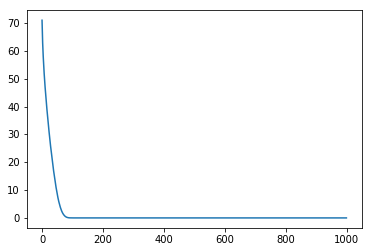

In [17]:
def test_adam():
    class QModel(ParameterizedModel):
        def __init__(self, A):
            self.A = A
        def forward(self, input):
            A = self.A
            out = torch.einsum('bi,ij,bj->b', input, A, input)
            assert out.dim() == 1
            return out
        def parameters(self):
            return (self.A,)
    n = 5
    true_model = QModel(torch.randn(n, n))
    def make_batches():
        def batches(bs=128):
            for i in range(100):
                x = torch.randn(bs, n)
                y = true_model.forward(x)
                yield (x, y)
        return batches()
    trainable = QModel(torch.randn(n, n, requires_grad=True))
    opt = Adam(trainable.parameters(), lr=.1)
    lossporn = []
    x_test = next(make_batches())[0]
    opt.register_epoch_posthook(lambda e, model: lossporn.append(torch.norm(model.forward(x_test) - true_model.forward(x_test))))
    loss = lambda pred, labels: torch.norm(pred - labels)**2
    opt.evolve(trainable, loss, make_batches, 1000)
    fig, ax = plt.subplots()
    ax.plot(lossporn)
    with torch.no_grad():
        print(torch.norm(true_model.A - trainable.A))
test_adam()
plt.show()

(3, 1, 3, 3)
(3, 3, 3, 3)
(3, 3, 3, 3)
(3, 3, 3, 3)
(3, 3, 3, 3)
(3, 3, 3, 3)
(1, 3, 1, 1)
(784, 10)
(1, 10)


FigureCanvasNbAgg()

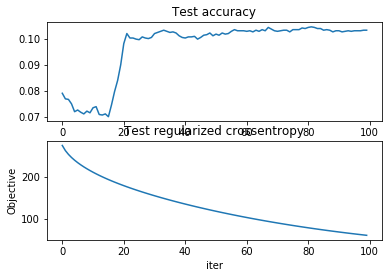

In [20]:
class AddExplicitChannel(ParameterizedModel):
    def forward(self, input):
        return input.unsqueeze(-3)
    def parameters(self):
        return tuple()
    
    
def WideResBlock(in_ch, out_ch, ks, p=.75):
    return Combine(Identity(),
                   Sequential(
                       Conv2d(in_ch, out_ch, ks),
                       Dropout(p),
                       Conv2d(out_ch, out_ch, ks),
                       Apply(torch.relu)),
                   combinator=sum) # `sum` is suboptimal!


def make_wide_resnet():
    network = Sequential(
        AddExplicitChannel(),
        # PrintShape("dummy channel"),
        WideResBlock(1, 3, 3, .5),
        # PrintShape("res1"),
        WideResBlock(3, 3, 3, .5),
        # PrintShape("res1"),
        WideResBlock(3, 3, 3, .5),
        # PrintShape("res1"),
        Conv2d(3, 1, 1, # merge to just one channel
               padding=0), # otherwise width and height get increased by 2
        # PrintShape("1x1"),
        Flatten(),
        Apply(torch.relu),
        # PrintShape("flattened"),
        Linear(28*28, 10),
        Apply(torch.relu),
        Apply(torch.softmax, -1)
    )
    for p in network.parameters():
        with torch.no_grad():
            p.uniform_(-1./np.sqrt(float(sum(p.shape))))
        p.requires_grad_(True)
    return network


model = PredictiveModel(make_wide_resnet())
print('\n'.join([str(tuple(x.shape)) for x in model.parameters()]))

# Your code here (train the model)
def do(n_epochs):
    fig, (ax_acc, ax_logloss) = plt.subplots(2)
    opt = Adam(model.parameters(), .1)
    hist_acc, hist_loss = [], []
    def custom_loss(pred, labels):
        return crossentropy(pred, labels) + .1 * sum(p.norm()**2 for p in model.parameters())
    def epoch_posthook(epoch, model):
        try:
            model.set_mode(training=False)
            model.requires_grad_(False)
            X, y = X_test, y_test
            acc = accuracy(model, X, y)
            with torch.no_grad():
                loss = custom_loss(model.forward(X), y)
            hist_acc.append(acc)
            hist_loss.append(loss)
            ax_logloss.clear()
            ax_logloss.set_title('Test regularized crossentropy')
            ax_logloss.set_xlabel('iter')
            ax_logloss.set_ylabel('Objective')
            ax_logloss.plot(hist_loss)
            ax_acc.clear()
            ax_acc.set_xlabel('iter')
            ax_acc.set_title('Test accuracy')
            ax_acc.plot(hist_acc)
            fig.canvas.draw()
        finally:
            model.set_mode(training=True)
            model.requires_grad_(True)
    opt.register_epoch_posthook(epoch_posthook)
    opt.evolve(model,
               custom_loss,
               lambda: make_epoch_batches(X_train, y_train, 256),
               n_epochs)

do(100)

In [ ]:
model.forward(X_train)

In [ ]:
train_acc = accuracy(model, X_train, y_train) * 100
test_acc = accuracy(model, X_test, y_test) * 100
print("Train accuracy: %.2f, test accuracy: %.2f" % (train_acc, test_acc))

assert test_acc >= 82.0, "You have to do better"

In [ ]:
do(500)